In [1]:
# -*- coding: utf-8 -*-
import argparse
import copy
import json
import os
import pickle
import random
import sys
import re
import numpy as np
import openai

from utils import *

os.environ["http_proxy"] = "http://localhost:7890"
os.environ["https_proxy"] = "http://localhost:7890"

GPT_MODEL = "gpt-4-turbo-preview"  # [gpt-4-turbo-preview]

setOpenAi(keyid = 2)

0

#### 任务分解

In [2]:
GPT_MODEL = "gpt-4-turbo-preview"  # [gpt-4-turbo-preview]]

problem = """ "turn around left thrice after run around right thrice" """   
# 后备选项是: "turn right after run left thrice"

decom_system = {"role": "system", "content": """I will give you a piece of natural language command. I need you to decompose it to smaller commands.
8 examples are as follows:

Q: "look right after look twice"
A: "look right after look twice" can be solved by: "look right", "look twice".

Q: "jump opposite right thrice and walk"
A: "jump opposite right thrice" can be solved by: "jump opposite right", "jump opposite right thrice". "walk" can be solved by: "walk". So, "jump opposite right thrice and walk" can be solved by: "jump opposite right", "jump opposite right thrice", "walk".

Q: "run left twice and run right"
A: "run left twice" can be solved by: "run left", "run left twice". "run right" can be solved by "run right". So, "run left twice and run right" can.be solved by: "run left", "run left twice", "run right".

Q: "run opposite right"
A: "run opposite right" can be solved by "run opposite right".

Q: "look opposite right thrice after walk"
A: "look opposite right thrice" can be solved by: "look opposite right", "look opposite right thrice". "walk" can be solved by "walk". So, "look opposite right thrice after walk" can be solved by: "look opposite right", "look opposite right thrice", "walk".

Q: "jump around right"
A: "jump around right" can be solved by: "jump right", "jump around right". So, "jump around right" can be solved by: "jump right", "jump around right".

Q: "look around right thrice and walk"
A: "look around right thrice" can be solved by: "look right", "look around right", "look around right thrice". "walk" can be solved by "walk". So, "look around right thrice and walk" can be solved by: "look right", "look around right", "look around right thrice", "walk".

Q: "turn right after run right thrice"
A: "turn right" can be solved by: "turn right". "run right thrice" can be solved by: "run right", "run right thrice". So, "turn right after run right thrice" can be solved by: "turn right", "run right", "run right thrice".
"""}

question = {"role": "user", "content": f"""Now the command is {problem}, please decompose it into smaller commands like the examples.
Format: "Command" can be solved by: "subcommand_0", "subcommand_1",...  """}
decom_Q = [decom_system, question]
decom_commands = askChatGPT(decom_Q, model=GPT_MODEL, temperature = 1)
print('LLM回答的分解方法:', decom_commands)

# 正则表达式匹配 can be solved by: 之后的引号中的内容
pattern = r'can be solved by:\s*("[^"]*"(?:,\s*"[^"]*")*)'

# 查找匹配项
match = re.search(pattern, decom_commands)

# 提取匹配内容并转换为列表
if match:
    # 提取逗号分隔的引号中的内容
    commands_decomposed = re.findall(r'"([^"]*)"', match.group(1))
    print('提取后的commands list: ', commands_decomposed)
else:
    print("没有找到匹配的内容")


LLM回答的分解方法: "turn around left thrice after run around right thrice" can be solved by: "run right", "run around right", "run around right thrice", "turn left", "turn around left", "turn around left thrice".
提取后的commands list:  ['run right', 'run around right', 'run around right thrice', 'turn left', 'turn around left', 'turn around left thrice']


#### 定义元关系

In [3]:
problem
commands_decomposed
connect_system = {"role": "system", "content": """Now we have a natural language instruction, which we have broken down into many subcommands in the form of a list. I want you to understand the connection between these subcommands."""}
connect_user = {"role": "user", "content":f"The init natural language instruction is {problem}. And the subcommands are {commands_decomposed} Please provide your understanding of the relationships between these subcommands."}
connect_Q = [connect_system, connect_user]
connect_commands = askChatGPT(connect_Q, model=GPT_MODEL, temperature = 1)

print('LLM对于subcommands之间关系的语言理解', connect_commands)

LLM对于subcommands之间关系的语言理解 The natural language instruction "turn around left thrice after run around right thrice" involves a sequence of actions broken down into more detailed steps, represented by the subcommands. Let's understand their connection step-by-step, focusing on how they build upon each other to fulfil the overarching instruction.

1. **Base Actions:** The instruction involves two primary types of actions: "run" and "turn". These are the foundational movements from which the more complex actions are derived.

2. **Directional Modifiers:** Each action is modified by a direction:
   - "right" for running
   - "left" for turning
   
   This specifies the direction in which each action should be executed.

3. **Intensifiers:**
   - "around" intensifies the base action by implying a more complete or encompassing movement. 
      - "run right" becomes "run around right", 
      - "turn left" becomes "turn around left". 
   - "thrice" adds a frequency modifier to the "around" act

#### 抽象关系图建立
1. progressive connection
2. parallel connection 并行之后是需要一个聚合操作的

In [4]:
# 定义图的元操作: 聚合
element_system = {"role":"system", "content":"""Now we need to create a standardized model for the relationships between subcommands. We have defined two basic relationships:
1. Progressive: This means that subcommand 2 is the direct subsequent step to subcommand 1, providing a detailed explanation and additional requirements for subcommand 1. The result of subcommand 2 can directly override the result of subcommand 1 for subsequent reasoning.
2. Parallel: This means that subcommand 1 and subcommand 2 are two parallel steps. They are independent, with results that are somewhat related but not interchangeable. They can be handled separately and then aggregated.
"""}
element_Q =  {"role": "user", "content":"""Now please rewrite your understanding of the relationship between subcommands using 'progressive' and 'parallel'.
Answer format: 
1. "xxx1" progressive "xxx2"
2. "xxx2" parallel "xxx3"
3. ...

Notice that "xxx1" progressive "xxx2" means "xxx2" is the subsequent step to "xxx1".
"""}
connect_Q.append(element_system)
connect_Q.append(element_Q)
tuple_subcommands = askChatGPT(connect_Q, model=GPT_MODEL, temperature = 1)
print(tuple_subcommands)

1. "run right" progressive "run around right"
2. "run around right" progressive "run around right thrice"
3. "turn left" progressive "turn around left"
4. "turn around left" progressive "turn around left thrice"
5. "run around right thrice" parallel "turn around left thrice"


#### 结构化建图
 - 把语言结构化提取成三元组的形式

In [5]:
# print(connect_commands)

# 正则表达式模式,从语言描述中提取关系三元组
pattern = r'"\s*([^"]+)\s*"\s*(\w+)\s*"\s*([^"]+)\s*"'
# 使用正则表达式查找所有匹配的三元组
matches = re.findall(pattern, tuple_subcommands)
# 输出提取的关系三元组
for match in matches:
    print(match)


('run right', 'progressive', 'run around right')
('run around right', 'progressive', 'run around right thrice')
('turn left', 'progressive', 'turn around left')
('turn around left', 'progressive', 'turn around left thrice')
('run around right thrice', 'parallel', 'turn around left thrice')


#### 可视化

In [ ]:
from graphviz import Digraph
from IPython.display import display, Image

# 定义关系描述的三元组
relationships = [
    ('run left', 'progressive', 'run left thrice'),
    ('run left thrice', 'parallel', 'turn right')
]

# 创建有向图
dot = Digraph(comment='Process Flow')
    
# 用于存储并行关系的集合
parallel_pairs = []

# 添加节点和边
for obj1, relation, obj2 in relationships:
    dot.node(obj1, obj1)
    dot.node(obj2, obj2)
    
    if relation == 'progressive':
        dot.edge(obj1, obj2, label='progressive')
    elif relation == 'parallel':
        parallel_pairs.append((obj1, obj2))

# 添加并行关系的无箭头虚线和共同指向的result节点
if parallel_pairs:
    with dot.subgraph() as s:
        for obj1, obj2 in parallel_pairs:
            s.node(obj1, obj1)
            s.node(obj2, obj2)
            s.edge(obj1, obj2, style='dotted', arrowhead='none', label='parallel')
        s.node('result', 'result')
        for obj1, obj2 in parallel_pairs:
            s.edge(obj1, 'result', style='dotted') # arrowhead='none'
            s.edge(obj2, 'result', style='dotted') # arrowhead='none'

# 保存并展示图表，增加分辨率参数
dot.attr(dpi='300')  # 设置dpi参数提高分辨率
dot.render('process_flow', format='png', view=True)

# 显示图像在Notebook中
display(Image(filename='process_flow.png', width=400, height=300))  # 设置图片宽度和高度

#### 对可视化代码进一步做了修改
 - 定义层级的概念
 - 同一层级的在同一高度

In [6]:
# 非常妙

relationships = matches
print(relationships)
        

# 初始化一个空字典来存储每个节点的深度
depths = {}

# 定义一个函数来更新深度
def update_depths():
    updated = False
    for obj1, relation, obj2 in relationships:
        if relation == 'progressive':
            if obj1 in depths:
                new_depth = depths[obj1] + 1
                if obj2 not in depths or depths[obj2] < new_depth:
                    depths[obj2] = new_depth
                    updated = True
            elif obj2 in depths:
                new_depth = depths[obj2] - 1
                if obj1 not in depths or depths[obj1] > new_depth:
                    depths[obj1] = new_depth
                    updated = True
        elif relation == 'parallel':
            if obj1 in depths and obj2 not in depths:
                depths[obj2] = depths[obj1]
                updated = True
            elif obj2 in depths and obj1 not in depths:
                depths[obj1] = depths[obj2]
                updated = True
            elif obj1 in depths and obj2 in depths:
                if depths[obj1] != depths[obj2]:
                    a_depth = max(depths[obj1], depths[obj2])  # 这里是min还是max非常玄妙,感觉这里可能会出现一些bugs
                    depths[obj1] = a_depth
                    depths[obj2] = a_depth
                    updated = True
                    
        print(depths)
    return updated

# 初始化所有节点的深度为0
for obj1, relation, obj2 in relationships:
    if obj1 not in depths:
        depths[obj1] = 0
    if obj2 not in depths:
        depths[obj2] = 0

# 不断更新深度，直到没有变化
count = 0
while update_depths():
    count += 1
    if count == 10:
        break
    pass

# 输出结果
print(depths)

# 创建一个新的字典来存储按照深度分类的节点
depth_groups = {}

# 迭代已有的节点深度字典
for node, depth in depths.items():
    if depth not in depth_groups:
        depth_groups[depth] = []
    depth_groups[depth].append(node)

# 输出结果
print(depth_groups)


[('run right', 'progressive', 'run around right'), ('run around right', 'progressive', 'run around right thrice'), ('turn left', 'progressive', 'turn around left'), ('turn around left', 'progressive', 'turn around left thrice'), ('run around right thrice', 'parallel', 'turn around left thrice')]
{'run right': 0, 'run around right': 1, 'run around right thrice': 0, 'turn left': 0, 'turn around left': 0, 'turn around left thrice': 0}
{'run right': 0, 'run around right': 1, 'run around right thrice': 2, 'turn left': 0, 'turn around left': 0, 'turn around left thrice': 0}
{'run right': 0, 'run around right': 1, 'run around right thrice': 2, 'turn left': 0, 'turn around left': 1, 'turn around left thrice': 0}
{'run right': 0, 'run around right': 1, 'run around right thrice': 2, 'turn left': 0, 'turn around left': 1, 'turn around left thrice': 2}
{'run right': 0, 'run around right': 1, 'run around right thrice': 2, 'turn left': 0, 'turn around left': 1, 'turn around left thrice': 2}
{'run ri

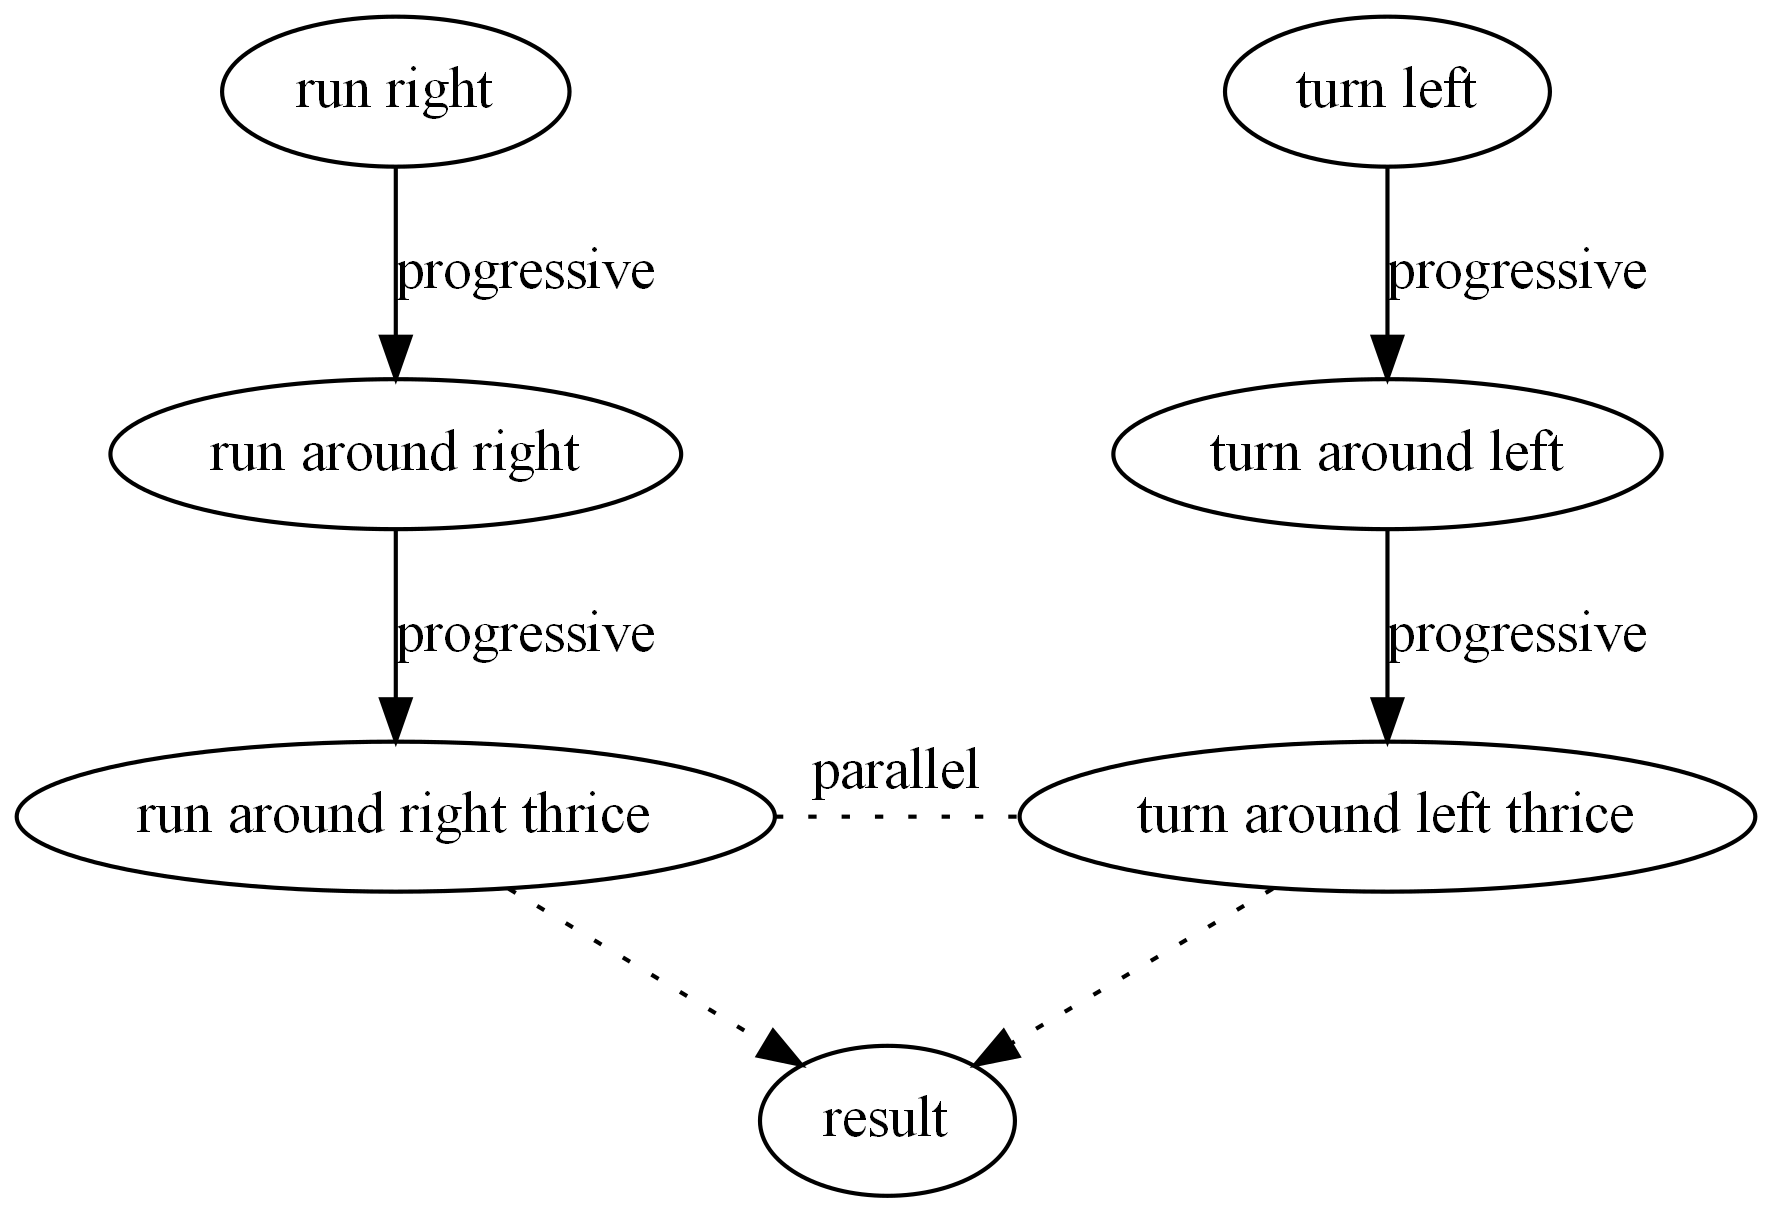

In [7]:
from graphviz import Digraph
from IPython.display import display, Image

# 定义关系描述的三元组
relationships = matches

# 创建有向图
dot = Digraph(comment='Process Flow')

# 用于存储并行关系的集合
parallel_pairs = []

# 添加节点和边
for obj1, relation, obj2 in relationships:
    dot.node(obj1, obj1)
    dot.node(obj2, obj2) 
    
    if relation == 'progressive':
        dot.edge(obj1, obj2, label='progressive')
    elif relation == 'parallel':
        parallel_pairs.append((obj1, obj2))

for depth, nodes in depth_groups.items():
    with dot.subgraph() as s:
        s.attr(rank='same')
        for node in nodes:
            s.node(node)

    
# # 手动分层
# with dot.subgraph() as s:
#     s.attr(rank='same')
#     s.node('run left')

# with dot.subgraph() as s:
#     s.attr(rank='same')
#     s.node('run left thrice')
#     s.node('turn right')
    
# with dot.subgraph() as s:
#     s.attr(rank='same')
#     s.node('result')

# 添加并行关系的无箭头虚线和共同指向的result节点
if parallel_pairs:
    with dot.subgraph() as s:
        for obj1, obj2 in parallel_pairs:
            s.node(obj1, obj1)
            s.node(obj2, obj2)
            s.edge(obj1, obj2, style='dotted', arrowhead='none', label='parallel')
        s.node('result', 'result')
        for obj1, obj2 in parallel_pairs:
            s.edge(obj1, 'result', style='dotted') # arrowhead='none'
            s.edge(obj2, 'result', style='dotted') # arrowhead='none'

# 保存并展示图表，增加分辨率参数
dot.attr(dpi='300')  # 设置dpi参数提高分辨率
dot.render('process_flow', format='png', view=True)

# 显示图像在Notebook中
display(Image(filename='process_flow.png', width=400, height=300))  # 设置图片宽度和高度
